In [2]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/_minimize.py:37: ImportWarning: Not importing directory '/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/scipy/optimize/lbfgsb': missing __init__.py
  from .lbfgsb import _minimize_lbfgsb


In [69]:
sns.__version__

'0.8.1'

## setup

In [3]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/megumisano/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [4]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run2_chairs1k_size6'

In [5]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

1115 stroke records in the database.
192 clickedObj records in the database.


## generate group dataframe

In [6]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [7]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,iterationName,researchers=researchers, tolerate_undefined_worker=False)

There was something wrong with this game 5976-3520ab05-033f-4cda-bb7f-8d93ab0956c4
There was something wrong with this game 0135-deee0e88-ce5a-48b1-99d5-cf1e3217a99f
There was something wrong with this game 4004-08fcac10-54da-4362-8b77-6869a2b4aa0a
There was something wrong with this game 5288-2608bf5a-2af4-438c-90df-032a479b3195
There was something wrong with this game 2153-fe370c60-795f-46f4-959e-4aa70ec7c4ed
There was something wrong with this game 2306-68150396-3082-458b-bf35-5683428df704
There was something wrong with this game 5662-7e3a93a5-e9a3-47b8-bdb4-bfe3f08c3ef9
There was something wrong with this game 2909-8200b9a1-435f-4c08-b71b-04bd71508910
There was something wrong with this game 8283-9b48bed2-3a8c-45ae-b706-649231363252
There was something wrong with this game 5428-1c065c92-f2c0-4c0f-bf37-9a7bc82fb832
There was something wrong with this game 1602-f09f5dc8-0f6a-46ab-9e09-ab12c700e9b5
There was something wrong with this game 3775-8f131e6c-5ac4-43ad-b290-c09b11dde8fa
Ther

In [8]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

_complete_games=['7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82', '5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9', '3176-1391c021-32cc-4034-8811-4ddafef4280f', 
                 '1217-816328d8-5486-410a-b18e-9578493b0f31', 
'1555-977bf072-b352-44e5-b00e-317349ddc158', '3663-5a7299be-30cf-4686-939e-b2f163df6889', '9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993', '8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73', 
'9340-a1124706-24cc-44f3-9097-ba0b33adbf36', '3511-727c76f4-f755-48e9-8fc8-b61efbe785c9']
for i,g in enumerate(_complete_games):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(_complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY_run2[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                # calculate numStrokes 
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
                numStrokes.append(lastStrokeNum)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
            
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82 | 0 of 10: 
Analyzing game 5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9 | 1 of 10: 
Analyzing game 3176-1391c021-32cc-4034-8811-4ddafef4280f | 2 of 10: 
Analyzing game 1217-816328d8-5486-410a-b18e-9578493b0f31 | 3 of 10: 
Analyzing game 1555-977bf072-b352-44e5-b00e-317349ddc158 | 4 of 10: 
Analyzing game 3663-5a7299be-30cf-4686-939e-b2f163df6889 | 5 of 10: 
Analyzing game 9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993 | 6 of 10: 
Analyzing game 8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73 | 7 of 10: 
Analyzing game 9340-a1124706-24cc-44f3-9097-ba0b33adbf36 | 8 of 10: 
Analyzing game 3511-727c76f4-f755-48e9-8fc8-b61efbe785c9 | 9 of 10: 


In [10]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game 
#D = D[D['gameID'] == '1180-2832f7d7-535a-4fb3-acf4-d40972f6d878']

# Just look at repeated trials and sort them by target and reps 
# _D = D[(D.condition=='repeated')]
# _D = _D.sort_values(by=['target','repetition'])
D

,gameID,trialNum,condition,target,category,repetition,phase,drawDuration,outcome,response,numStrokes,meanPixelIntensity,svgStringLength,svgStringLengthPerStroke,svgStringStd,numCurvesPerSketch,numCurvesPerStroke,timedOut,png
0,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,1,control,deck_07,deck,0,pre,19.823,True,deck_07,12,0.0714,1044,87,86.5833,29,2.41667,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,2,repeated,deck_05,deck,0,pre,10.001,True,deck_05,5,0.0583,971,194.2,283.699,28,5.6,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,3,repeated,deck_00,deck,0,pre,11.148,False,deck_06,7,0.0556,677,96.7143,57.5095,18,2.57143,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,4,control,deck_01,deck,0,pre,9.618,False,deck_03,6,0.0492,856,142.667,114.836,23,3.83333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,5,control,deck_03,deck,0,pre,21.78,True,deck_03,9,0.0489,1710,190,208.604,49,5.44444,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,6,repeated,deck_02,deck,0,pre,10.001,True,deck_02,4,0.0324,931,232.75,214.192,25,6.25,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,7,control,deck_04,deck,0,pre,8.032,True,deck_04,4,0.041,1016,254,57.0351,26,6.5,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,8,repeated,deck_06,deck,0,pre,11.418,True,deck_06,7,0.0732,1225,175,95.0368,32,4.57143,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,9,repeated,deck_02,deck,1,repeated,7.808,True,deck_02,5,0.0307,575,115,117.441,15,3,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,10,repeated,deck_00,deck,1,repeated,16.222,False,deck_06,12,0.0845,1489,124.083,111.114,38,3.16667,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


### seeing which cluster (category) reduced most

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 8)

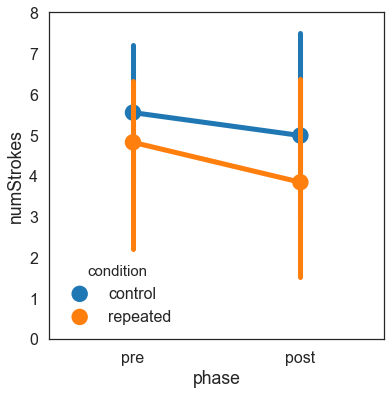

In [24]:
D_deck = D[D['category'] == 'deck']
_D_deck = D_deck[D_deck['phase']!='repeated']
_D_deck['numStrokes'] = _D_deck['numStrokes'].astype(int)
_D_deck_ = _D_deck.groupby(['gameID','phase','condition'])['numStrokes'].mean()
_D_deck_ = _D_deck_.reset_index()

plt.figure(figsize=(6,6))
sns.pointplot(data=_D_deck_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,8])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 12.5)

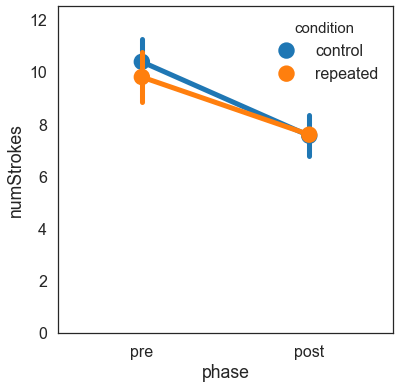

In [27]:
D_dining = D[D['category'] == 'dining']
_D_dining = D_dining[D_dining['phase']!='repeated']
_D_dining['numStrokes'] = _D_dining['numStrokes'].astype(int)
_D_dining_ = _D_dining.groupby(['gameID','phase','condition'])['numStrokes'].mean()
_D_dining_ = _D_dining_.reset_index()

plt.figure(figsize=(6,6))
sns.pointplot(data=_D_dining_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,12.5])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1 

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 12.5)

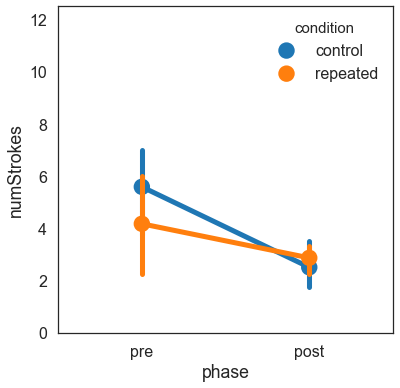

In [52]:
D_waiting = D[D['category'] == 'waiting']
_D_waiting = D_waiting[D_waiting['phase']!='repeated']
_D_waiting['numStrokes'] = _D_waiting['numStrokes'].astype(int)
_D_waiting_ = _D_waiting.groupby(['gameID','phase','condition'])['numStrokes'].mean()
_D_waiting_ = _D_waiting_.reset_index()

plt.figure(figsize=(6,6))
sns.pointplot(data=_D_waiting_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,12.5])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1 

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 12.5)

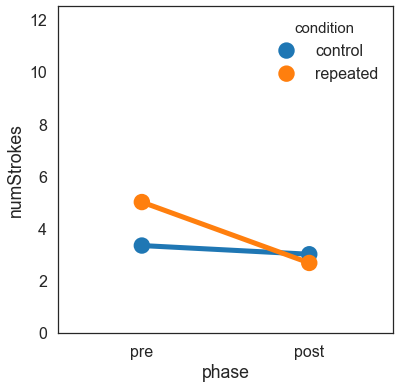

In [53]:
D_armchair = D[D['category'] == 'armchair']
_D_armchair = D_armchair[D_armchair['phase']!='repeated']
_D_armchair['numStrokes'] = _D_armchair['numStrokes'].astype(int)
_D_armchair_ = _D_armchair.groupby(['gameID','phase','condition'])['numStrokes'].mean()
_D_armchair_ = _D_armchair_.reset_index()
plt.figure(figsize=(6,6))
sns.pointplot(data=_D_armchair_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,12.5])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1 

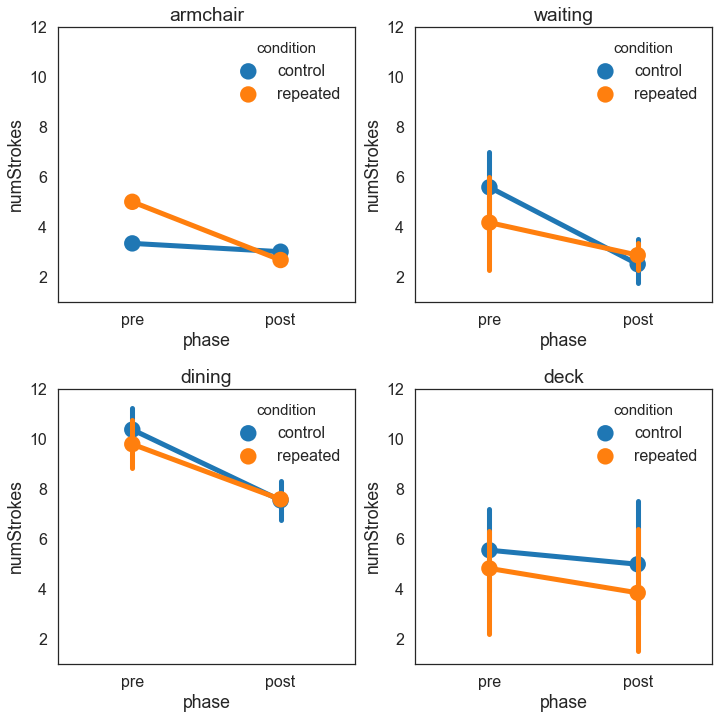

In [71]:
## plotting all four categories in a grid

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.pointplot(data=_D_armchair_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'],
         ax=ax0)    

sns.pointplot(data=_D_waiting_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'],
         ax=ax1)  

sns.pointplot(data=_D_dining_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'],
         ax=ax2)    

sns.pointplot(data=_D_deck_,
         x='phase',
         y='numStrokes',
         hue='condition',
         order=['pre','post'],
         ax=ax3)    

ax0.set_ylim([1, 12])
ax0.set_title('armchair')
ax1.set_ylim([1, 12])
ax1.set_title('waiting')
ax2.set_ylim([1, 12])
ax2.set_title('dining')
ax3.set_ylim([1, 12])
ax3.set_title('deck')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 1.1)

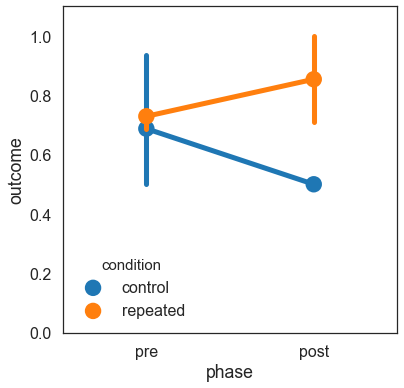

In [13]:
D_deck = D[D['category'] == 'deck']
_D_deck = D_deck[D_deck['phase']!='repeated']
_D_deck['outcome'] = _D_deck['outcome'].astype(int)
_D_deck_ = _D_deck.groupby(['gameID','phase','condition'])['outcome'].mean()
_D_deck_ = _D_deck_.reset_index()

plt.figure(figsize=(6,6))
sns.pointplot(data=_D_deck_,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

In [14]:
D_dining = D[D['category'] == 'dining']
_D_dining = D_dining[D_dining['phase']!='repeated']
_D_dining['outcome'] = _D_dining['outcome'].astype(int)
_D_dining_ = _D_dining.groupby(['gameID','phase','condition'])['outcome'].mean()
_D_dining_ = _D_dining_.reset_index()

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
D_waiting = D[D['category'] == 'waiting']
_D_waiting = D_waiting[D_waiting['phase']!='repeated']
_D_waiting['outcome'] = _D_waiting['outcome'].astype(int)
_D_waiting_ = _D_waiting.groupby(['gameID','phase','condition'])['outcome'].mean()
_D_waiting_ = _D_waiting_.reset_index()

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
D_armchair = D[D['category'] == 'armchair']
_D_armchair = D_armchair[D_armchair['phase']!='repeated']
_D_armchair['outcome'] = _D_armchair['outcome'].astype(int)
_D_armchair_ = _D_armchair.groupby(['gameID','phase','condition'])['outcome'].mean()
_D_armchair_ = _D_armchair_.reset_index()

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


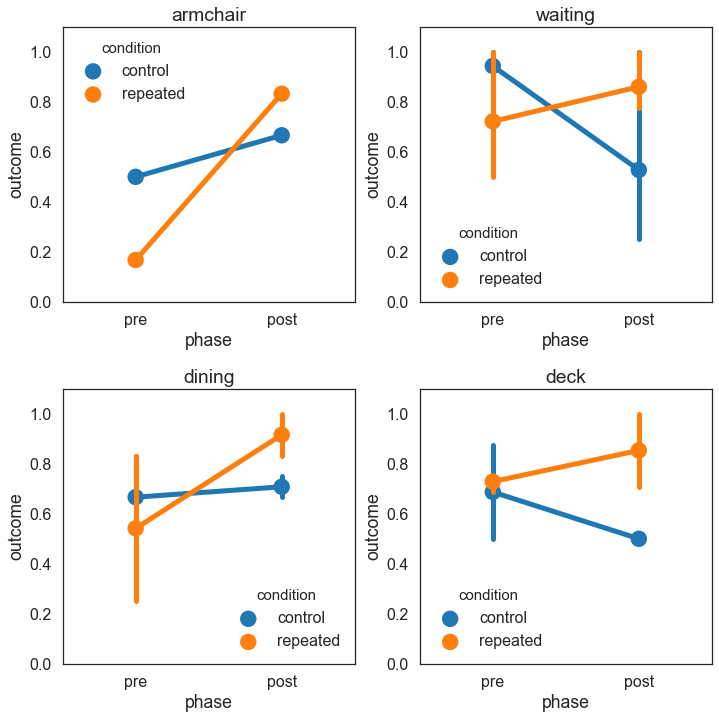

In [18]:
ig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.pointplot(data=_D_armchair_,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'],
         ax=ax0)    

sns.pointplot(data=_D_waiting_,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'],
         ax=ax1)  

sns.pointplot(data=_D_dining_,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'],
         ax=ax2)    

sns.pointplot(data=_D_deck_,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'],
         ax=ax3)    

ax0.set_ylim([0, 1.1])
ax0.set_title('armchair')
ax1.set_ylim([0, 1.1])
ax1.set_title('waiting')
ax2.set_ylim([0, 1.1])
ax2.set_title('dining')
ax3.set_ylim([0, 1.1])
ax3.set_title('deck')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [61]:
_D_armchair_['category'] = pd.Series(['armchair'] * _D_armchair_.shape[0])
_D_dining_['category'] = pd.Series(['dining'] * _D_dining_.shape[0])
_D_deck_['category'] = pd.Series(['deck'] * _D_deck_.shape[0])
_D_waiting_['category'] = pd.Series(['waiting'] * _D_waiting_.shape[0])

In [63]:
frames = [_D_armchair_, _D_dining_, _D_deck_, _D_waiting_]
D_all_categories = pd.concat(frames)

In [67]:
sns.catplot(x="phase", y="numStrokes",
...                 hue="condition", col="category",
...                 data=D_all_categories, kind="point",
...                 dodge=True,
...                 height=4, aspect=.7)

AttributeError: 'module' object has no attribute 'catplot'

In [44]:
armchair_strokes = _D_armchair_[_D_armchair_['condition'] == 'repeated']
armchair_strokes

,gameID,phase,condition,numStrokes
1,8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73,post,repeated,2.666667
3,8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73,pre,repeated,5.000000


In [45]:
dining_strokes = _D_dining_[_D_dining_['condition'] == 'repeated']
dining_strokes

,gameID,phase,condition,numStrokes
1,1555-977bf072-b352-44e5-b00e-317349ddc158,post,repeated,7.500000
3,1555-977bf072-b352-44e5-b00e-317349ddc158,pre,repeated,10.750000
5,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,post,repeated,7.666667
7,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,pre,repeated,8.833333


In [46]:
deck_strokes = _D_deck_[_D_deck_['condition'] == 'repeated']
deck_strokes

,gameID,phase,condition,numStrokes
1,1217-816328d8-5486-410a-b18e-9578493b0f31,post,repeated,1.000000
3,1217-816328d8-5486-410a-b18e-9578493b0f31,pre,repeated,1.000000
5,3511-727c76f4-f755-48e9-8fc8-b61efbe785c9,post,repeated,7.833333
7,3511-727c76f4-f755-48e9-8fc8-b61efbe785c9,pre,repeated,6.000000
9,3663-5a7299be-30cf-4686-939e-b2f163df6889,post,repeated,4.500000
11,3663-5a7299be-30cf-4686-939e-b2f163df6889,pre,repeated,6.500000
13,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,post,repeated,2.000000
15,7764-ec0b9363-37f0-4d02-8af7-bc27335b1a82,pre,repeated,5.750000


In [72]:
waiting_strokes = _D_waiting_[_D_waiting_['condition'] == 'repeated']
waiting_strokes

,gameID,phase,condition,numStrokes,category
1,3176-1391c021-32cc-4034-8811-4ddafef4280f,post,repeated,2.250000,waiting
3,3176-1391c021-32cc-4034-8811-4ddafef4280f,pre,repeated,2.250000,waiting
5,5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9,post,repeated,3.000000,waiting
7,5761-d75d770d-0013-4ba0-8d4f-7f4a635109d9,pre,repeated,4.250000,waiting
9,9340-a1124706-24cc-44f3-9097-ba0b33adbf36,post,repeated,3.333333,waiting
11,9340-a1124706-24cc-44f3-9097-ba0b33adbf36,pre,repeated,6.000000,waiting


(0.5, 1.0)

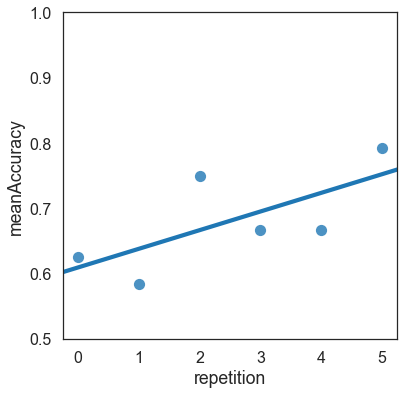

In [119]:
mean_accuracy_list = []
for i in range(0,6):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0.5,1.0])

### plot time series during repetition phase 

##### individual measures across reps (repeated trials only)

In [63]:
# What is the measure that you want to visualize across reps? 
dv = 'numCurvesPerSketch'

In [25]:
# D0 = h.ts_repeated(D,
#                                     var=dv,
#                                     limit=20, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
#                                     save_plot=False,
#                                     plot_dir=plot_dir)

##### individual measures across reps (repeated + control)

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


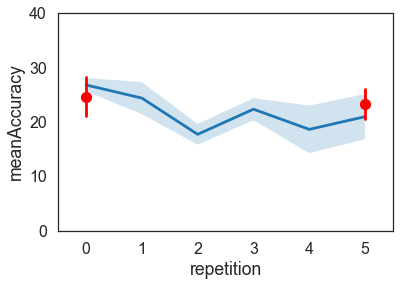

In [124]:
reload(h)
h.ts_repeated_control(D, 
                        var=dv,
                        numReps = 6,
                        limit=40, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

##### 4 measures (2x2) across reps (repeated + control) 

In [55]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3='numCurvesPerStroke'

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in 

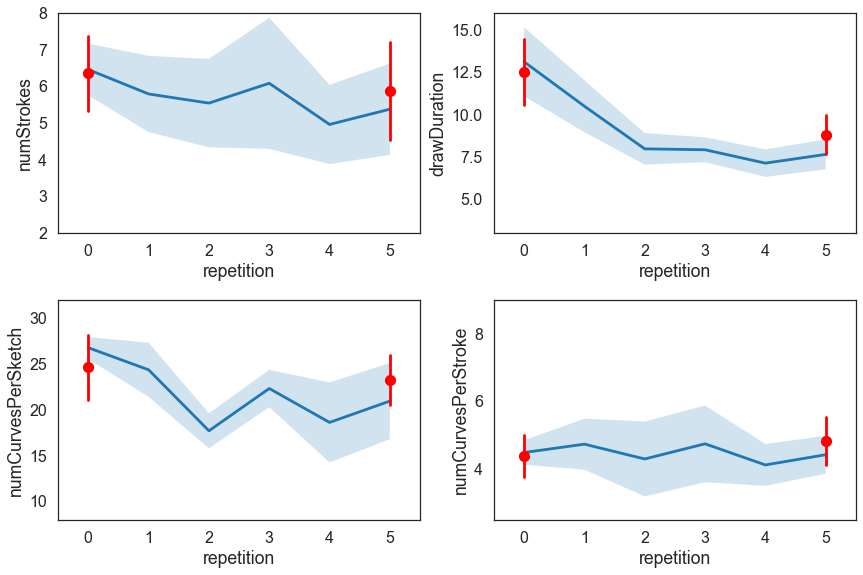

In [108]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=6,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

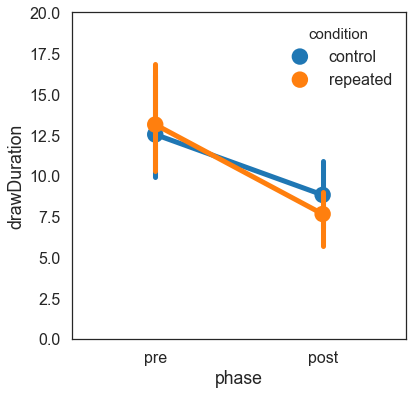

In [89]:
D1 = h.compare_conditions_prepost(D,
                                var='drawDuration',
                                limit=20,
                                save_plot=False,
                                plot_dir=plot_dir)

In [127]:
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)

D

/Users/megumisano/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until


,gameID,trialNum,condition,target,category,repetition,phase,drawDuration,outcome,response,numStrokes,meanPixelIntensity,svgStringLength,svgStringLengthPerStroke,svgStringStd,numCurvesPerSketch,numCurvesPerStroke,timedOut,png
0,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,1,control,dining_00,dining,0,pre,16.450,1,dining_00,13.0,0.0729,1721,132.385,123.287,44,3.384615,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
1,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,2,repeated,dining_05,dining,0,pre,7.555,1,dining_05,8.0,0.0575,1120,140,125.063,27,3.375000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
2,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,3,repeated,dining_11,dining,0,pre,9.789,1,dining_11,11.0,0.0439,1118,101.636,98.067,29,2.636364,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
3,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,4,control,dining_02,dining,0,pre,12.264,1,dining_02,8.0,0.06,1148,143.5,170.668,29,3.625000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
4,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,5,control,dining_04,dining,0,pre,11.661,0,dining_00,11.0,0.0688,1315,119.545,80.7604,34,3.090909,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
5,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,6,control,dining_10,dining,0,pre,11.914,1,dining_10,9.0,0.0316,1335,148.333,143.961,35,3.888889,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
6,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,7,control,dining_06,dining,0,pre,14.025,1,dining_06,10.0,0.0485,1434,143.4,126.848,38,3.800000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
7,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,8,repeated,dining_07,dining,0,pre,11.156,1,dining_07,10.0,0.0672,1705,170.5,104.041,46,4.600000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
8,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,9,repeated,dining_03,dining,0,pre,6.994,1,dining_03,5.0,0.0146,744,148.8,78.4051,19,3.800000,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...
9,9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993,10,control,dining_08,dining,0,pre,6.456,1,dining_08,6.0,0.0261,809,134.833,112.823,20,3.333333,False,iVBORw0KGgoAAAANSUhEUgAAASwAAAEsCAYAAAB5fY51AA...


In [128]:
D['outcome'] = D['outcome'].astype(int)

(0, 1.1)

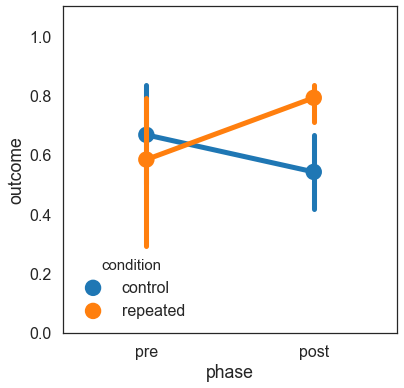

In [131]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

 ### visualize how sketches are changing across repetitions

In [17]:
# print_repeated_sketches(D,
#                                      complete_games,
#                                      sketch_dir)

In [18]:
# print_control_sketches(D,
#                                    complete_games,
#                                    sketch_dir)

In [126]:
_valid_gameids = complete_games

for g in _valid_gameids:
    #print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        newD = pd.DataFrame()
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(10,10))
        for i,_d in _D.iterrows():
            if (i -1)%6 == 0:
                newD.append()
                newD.append
#             imgData = _d['png']
#             filestr = base64.b64decode(imgData)
#             fname = 'sketch.png'
#             with open(fname, "wb") as fh:
#                 fh.write(imgData.decode('base64'))
#             textsize = 16
#             # first plot the target
#             im = Image.open(fname)
#             p = plt.subplot(6,6,_i)
#             plt.imshow(im)
#             sns.set_style('white')
#             k = p.get_xaxis().set_ticklabels([])
#             k = p.get_yaxis().set_ticklabels([])
#             k = p.get_xaxis().set_ticks([])
#             k = p.get_yaxis().set_ticks([]) 
#             outcome = _d['outcome']
#             category = _d['category']
#             if outcome == 1:
#                 sides = ['bottom','top','right','left']
#                 for s in sides:
#                     p.spines[s].set_color((0.4,0.8,0.4))
#                     p.spines[s].set_linewidth(4)                               
#             else:
#                 sides = ['bottom','top','right','left']
#                 for s in sides:
#                     p.spines[s].set_color((0.9,0.2,0.2))
#                     p.spines[s].set_linewidth(4)    
#             if (_i-1 < 6) & (tt in 'repeated'): 
#                 plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
#             if (_i-1)%6==0:
#                 plt.ylabel(_d['target'] ,fontsize=textsize)
                

#             _i  = _i + 1

#         filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
#         if not os.path.exists(os.path.join(sketch_dir,'repeated')):
#             os.makedirs(os.path.join(sketch_dir,'repeated'))
#         plt.tight_layout()

                                       gameID trialNum condition     target  \
11  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       12  repeated  dining_01   
17  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       18  repeated  dining_01   
18  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       19  repeated  dining_01   
27  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       28  repeated  dining_01   
34  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       35  repeated  dining_01   
36  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       37  repeated  dining_01   
8   9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993        9  repeated  dining_03   
12  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       13  repeated  dining_03   
20  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       21  repeated  dining_03   
26  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       27  repeated  dining_03   
35  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       36  repeated  dining_03   
38  9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993       

                                       gameID trialNum condition       target  \
50  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73        3  repeated  armchair_01   
64  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       17  repeated  armchair_01   
71  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       24  repeated  armchair_01   
74  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       27  repeated  armchair_01   
79  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       32  repeated  armchair_01   
86  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       39  repeated  armchair_01   
49  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73        2  repeated  armchair_02   
61  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       14  repeated  armchair_02   
67  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       20  repeated  armchair_02   
73  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       26  repeated  armchair_02   
83  8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73       36  repeated  armchair_02   
84  8640-15cf6802-aa7c-4aff-

                                        gameID trialNum condition      target  \
102  9340-a1124706-24cc-44f3-9097-ba0b33adbf36        7  repeated  waiting_02   
111  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       16  repeated  waiting_02   
117  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       22  repeated  waiting_02   
123  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       28  repeated  waiting_02   
128  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       33  repeated  waiting_02   
132  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       37  repeated  waiting_02   
96   9340-a1124706-24cc-44f3-9097-ba0b33adbf36        1  repeated  waiting_03   
112  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       17  repeated  waiting_03   
116  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       21  repeated  waiting_03   
125  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       30  repeated  waiting_03   
131  9340-a1124706-24cc-44f3-9097-ba0b33adbf36       36  repeated  waiting_03   
137  9340-a1124706-24cc-44f3

                                        gameID trialNum condition   target  \
145  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9        2  repeated  deck_02   
158  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       15  repeated  deck_02   
166  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       23  repeated  deck_02   
171  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       28  repeated  deck_02   
176  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       33  repeated  deck_02   
185  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       42  repeated  deck_02   
144  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9        1  repeated  deck_03   
161  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       18  repeated  deck_03   
164  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       21  repeated  deck_03   
169  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       26  repeated  deck_03   
177  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       34  repeated  deck_03   
181  3511-727c76f4-f755-48e9-8fc8-b61efbe785c9       38  repeate

### WORKING AREA

In [ ]:
## collapsing across objects within repetition (within pair) 
D0_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()
D1_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()
D2_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()
D3_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()

D0_control = ((D_control.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()).replace(1, 7) # rescale control reps 
D1_control = ((D_control.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()).replace(1, 7) # rescale control reps 
D2_control = ((D_control.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()).replace(1, 7) # rescale control reps 
D3_control = ((D_control.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()).replace(1, 7) # rescale control reps 

In [ ]:

# sns.tsplot(data=D0_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var0,
#            ax=ax0)

# sns.tsplot(data=D0_control,
#                time='repetition',
#                unit='gameID',
#                value=var0,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax0,
#                color='r')

# sns.tsplot(data=D1_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var1,
#            ax=ax1)

# sns.tsplot(data=D1_control,
#                time='repetition',
#                unit='gameID',
#                value=var1,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax1,
#                color='r')

# sns.tsplot(data=D2_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var2,
#            ax=ax2)

# sns.tsplot(data=D2_control,
#                time='repetition',
#                unit='gameID',
#                value=var2,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax2,
#                color='r')

# sns.tsplot(data=D3_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var3,
#            ax=ax3)

# sns.tsplot(data=D3_control,
#                time='repetition',
#                unit='gameID',
#                value=var3,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax3,
#                color='r')

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# ax0.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax1.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax2.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax3.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
# for i in range(0, 4):
#     var = 'var'+ i
#     print var
#     'D' + str(i) + '_' + condition = collapse_within_repetition(D, var, condition)

In [ ]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

def collapse_within_repetition(D, var, condition):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()).replace(1,7)
    
def plot_repeated_control(D_repeated, D_control, var, ax):
    sns.tsplot(data=D_repeated,
           time='repetition',
           unit='gameID',
           value=var,
           ax=ax)

    sns.tsplot(data=D_control,
               time='repetition',
               unit='gameID',
               value=var,
               err_style='ci_bars',
               interpolate=False,
               ax=ax,
               color='r')
    
    ax.set(xlim=(-0.5, 7.5), xticks=range(0,8))

# Miscellaneous

In [ ]:
#seaborn plotting

d = pd.DataFrame()
numReps = 7
variable = 'numStrokes'
# repeated conditions 
criteria_repeated = (D['condition']=='repeated')
repeated = D[criteria_repeated] # get all repeated condition trials 
repeats = list(range(0, numReps)) # number of repeats
repeated_means = []
for rep in repeats:
    mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
    repeated_means.append(mean)

# control conditions 
criteria_control = (D['condition']=='control')
control = D[criteria_control] # get all control condition trials 
controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
control_means= []
for i in [0, 1]: # only 2 controls, but should scale up to numReps 
    mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
    control_means.append(mean)

d['numReps'] = repeats
d[variable] = repeated_means
#d['control'] = control_means
facet = sns.lmplot(data=d, x='numReps', y=variable, fit_reg=False)
# add error bars 

In [ ]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

NameError: name 'control_strokes' is not defined

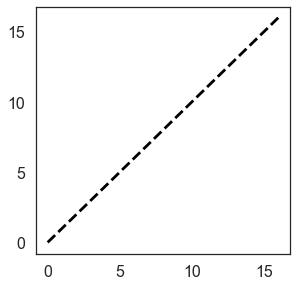

In [16]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [ ]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']